In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

In [2]:
# get the data
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2024-04-08 11:44:00--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: 'sp500sub.csv'

sp500sub.csv        100%[===================>]  24.29M  14.3MB/s    in 1.7s    

2024-04-08 11:44:03 (14.3 MB/s) - 'sp500sub.csv' saved [25473876/25473876]



In [44]:
# Explore the data 

df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

df.head()


,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [45]:
# Data contains indicators for multiple stocks/tickers 

df.Name.unique()

array(['INCY', 'GILD', 'DXC', 'AFL', 'XYL', 'ARE', 'AMD', 'WYNN', 'IBM',
       'ATVI', 'AES', 'GPC', 'PRU', 'HST', 'WMB', 'GOOG', 'SRE', 'HSIC',
       'UNP', 'UPS', 'K', 'LYB', 'MDT', 'COF', 'HAS', 'CSX', 'GT', 'SYF',
       'EBAY', 'KSS', 'AJG', 'JWN', 'SBUX', 'IT', 'PH', 'DVN', 'MMM',
       'SPG', 'AKAM', 'IP', 'CPB', 'KMI', 'AAPL', 'NEM', 'KMX', 'TSCO',
       'SYY', 'VNO', 'NWS', 'NBL', 'ACN', 'APH', 'PDCO', 'WLTW', 'FIS',
       'URI', 'CBOE', 'FISV', 'BA', 'UAA', 'CVS', 'WU', 'SLB', 'AIV',
       'VLO', 'MU', 'CAH', 'AZO', 'CCI', 'ZTS', 'MCO', 'ALLE', 'RHI',
       'UAL', 'IR', 'CB', 'VMC', 'GD', 'AAP', 'NEE', 'ABT', 'WFC', 'DIS',
       'SNA', 'MAR', 'JPM', 'CLX', 'KIM', 'SCG', 'HBI', 'ABBV', 'RSG',
       'ETR', 'ADBE', 'COO', 'HLT', 'INTU', 'SLG', 'GWW', 'COG', 'CBS',
       'FB', 'CMS', 'MDLZ'], dtype=object)

In [46]:
# we will work with google 

goog = df[df.Name == 'GOOG'][['Close']].copy()

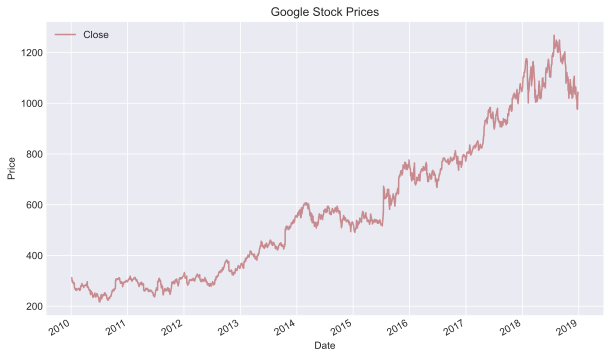

In [47]:
fig, axes = plt.subplots(figsize = (10,6))

goog.plot(ax = axes, color = 'brown', alpha = 0.5)

axes.set_ylabel('Price')
axes.set_title('Google Stock Prices')

axes.grid()

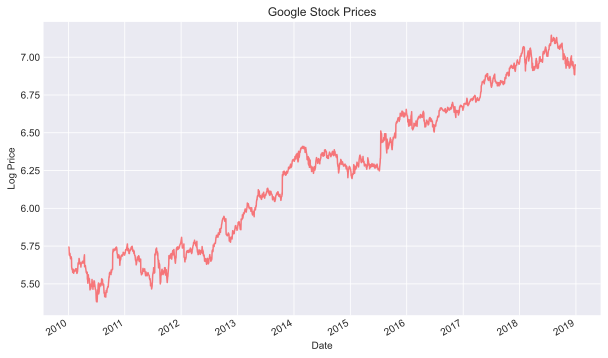

In [48]:
# log prices 

goog['Log_Close'] = np.log(goog['Close'])

fig, axes = plt.subplots(figsize = (10,6))

goog['Log_Close'].plot(ax = axes, color = 'red', alpha = 0.5)

axes.set_ylabel('Log Price')
axes.set_title('Google Stock Prices')

axes.grid()


In [49]:
# train test split 

Ntest = 30

train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

# boolean series to slice the df horizontally according to the train test split 

train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [50]:
# train the model 

hw = ExponentialSmoothing(goog['Log_Close'],trend = 'add', seasonal=None, initialization_method='legacy-heuristic')

res_hw= hw.fit()

res_hw.summary()

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,Log_Close,No. Observations:,2263
Model:,ExponentialSmoothing,SSE,0.535
Optimized:,True,AIC,-18887.022
Trend:,Additive,BIC,-18864.125
Seasonal:,None,AICC,-18886.985
Seasonal Periods:,None,Date:,"Mon, 08 Apr 2024"
Box-Cox:,False,Time:,12:31:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.0055897,beta,True


In [51]:
# since we cant able to set the frequency of the data set, .forecast() method messes up with the future dates 

goog.loc[train_idx, 'HW_pred'] = res_hw.fittedvalues
goog.loc[test_idx, 'HW_pred'] = res_hw.forecast(Ntest).to_numpy()


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [52]:
goog.tail()

,Close,Log_Close,HW_pred
Date,,,
2018-12-21,979.539978,6.887083,6.942494
2018-12-24,976.219971,6.883688,6.942430
2018-12-26,1039.459961,6.946457,6.942366
2018-12-27,1043.880005,6.950700,6.942301
2018-12-28,1037.079956,6.944164,6.942237


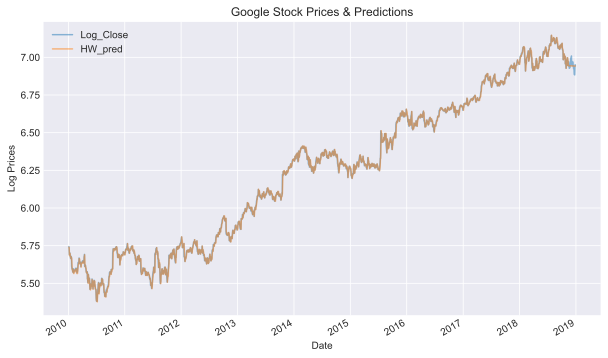

In [53]:
# Plot the predictions 

cols = goog.columns.to_list()

fig, axes = plt.subplots(figsize = (10,6))

goog[cols[1:]].plot(ax = axes, alpha = 0.5)

axes.set_ylabel('Log Prices')
axes.set_title('Google Stock Prices & Predictions')

axes.grid()

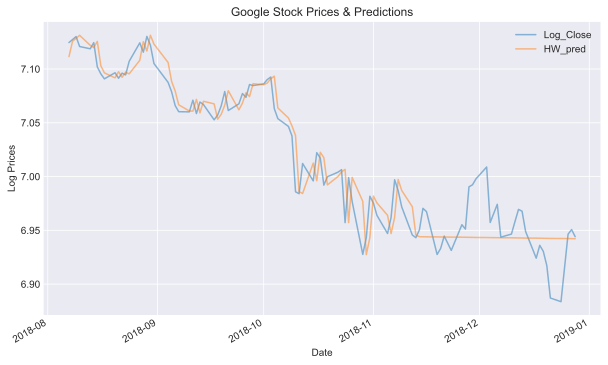

In [54]:
# Zoomed in Plot for the predictions 

cols = goog.columns.to_list()

fig, axes = plt.subplots(figsize = (10,6))

goog.iloc[-100:][cols[1:]].plot(ax = axes, alpha = 0.5)

axes.set_ylabel('Log Prices')
axes.set_title('Google Stock Prices & Predictions')

axes.grid()

These results are not surprising: T. he model only appear to do well on the training set because it copies the last value, e.g it predicts the next value using the previous value in the time-series. This makes sense because log prices nearly follow a random walk. The forecasts are linear because we used Holt's linear trend model. 

In [56]:
# Compare these predictions with the naive forecast, which is a horizontal line through the forecast horizon set by the final values in the training set 

goog.loc[test_idx, 'Naive'] = train.iloc[-1]['Log_Close']

In [57]:
goog.head()

,Close,Log_Close,HW_pred,Naive
Date,,,,
2010-01-04,312.204773,5.743659,5.739246,NaN
2010-01-05,310.829926,5.739246,5.739271,NaN
2010-01-06,302.994293,5.713714,5.734857,NaN
2010-01-07,295.940735,5.690159,5.709207,NaN
2010-01-08,299.885956,5.703402,5.685546,NaN


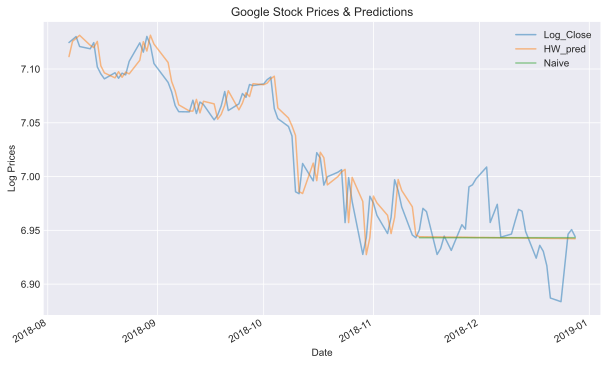

In [58]:
# Compare visually the naive forecast with Holt's linear trend model

cols = goog.columns.to_list()

fig, axes = plt.subplots(figsize = (10,6))

goog.iloc[-100:][cols[1:]].plot(ax = axes, alpha = 0.5)

axes.set_ylabel('Log Prices')
axes.set_title('Google Stock Prices & Predictions')

axes.grid()

In [59]:
# Compare quantitatively naive vs Holt's Linear trend model 

r2_hl = r2_score(goog.loc[test_idx,'Log_Close'],goog.loc[test_idx,'HW_pred'])

r2_n = r2_score(goog.loc[test_idx,'Log_Close'],goog.loc[test_idx,'Naive'])

print(f"R^2 for Holt's Linear trens model and the naive forecast are: {r2_hl:.2f} and {r2_n:.2f}")

R^2 for Holt's Linear trens model and the naive forecast are: -0.05 and -0.06


These results indicate that our does slightly better than the naive model. More importantly negative $R^2$ would imply that our model is doing a terrible job explaning the data! 

$$ R^2  = 1 - \frac{\textrm{RSS}}{\textrm{TSS}} $$

so that we have $\textrm{RSS} > \textrm{TSS}$ implying that residual squared sum is larger than the total squared sum. 